In [254]:
import os
import pandas as pd
from collections import Counter
import numpy as np

In [255]:
def normalize(x):
    u = np.mean(x)
    sig = np.std(x)
    z = (x - u)/sig
    return z, u, sig

def striplist(l):
    return([x.strip() for x in l])

def cant_diag(data, position):
    
    cant_diag = np.array([])

    for i in range(len(data)):       
         
        m_row = i
        
        mstring_A = data.iloc[m_row,position]
        mylist_A = striplist(mstring_A.split(','))
    
        counter = 0
    
        for j in mylist_A:          
            if j != 'ND':
                counter = counter +1              
        
        cant_diag = np.append(cant_diag, counter)
    
    return(cant_diag)    

def paid_indicator(x):
    x = np.array(x)    
    return np.where(x == 0, 0, 1)

def n_meses(data, start_pm):
    
    m_stack = np.zeros(shape=(data.shape[0],12))
    
    for i in range(12):        
        m_stack[:,i] = paid_indicator(data.iloc[:,start_pm + 2*i])
        
    dt = np.sum(m_stack,axis=1)
    return dt 

In [256]:
os.chdir('C:\\Users\\rober\\Desktop\\Humana_2\\Data_1');

data = pd.read_csv("BASE_TRAIN_MODELOS.csv", sep=',', encoding = "ISO-8859-1")
data_test = pd.read_csv("BASE_TEST_MODELOS.csv", sep=',', encoding = "ISO-8859-1")
data_pred = pd.read_csv("BASE_PREDICT_MODELOS.csv", sep=',', encoding = "ISO-8859-1")

In [257]:
data.head(3)

,AFILIADO,EXP,GENERO,EDAD,TOPE,PRODUCTO,PRIMA_A.1,PERIODO,PAGADO_A.1,PAGADO_A,...,NRO_TRANS_A_8,PAGADO_A_9,NRO_TRANS_A_9,PAGADO_A_10,NRO_TRANS_A_10,PAGADO_A_11,NRO_TRANS_A_11,PAGADO_A_12,NRO_TRANS_A_12,C_DIAG
0,ABAD AREVALO CARLA MARA,1,FEMENINO,40,4500,METROHUMANA,825.96,2014-2015,15.00,17.18,...,0,0.00,0,0.00,0,0.00,0,0.00,0,1
1,ABAD CABANILLA CARMEN BEATRIZ,1,FEMENINO,40,4500,BIENESTAR PLUS PRACTIHUMANA,1048.40,2014-2015,152.75,368.85,...,0,45.17,2,26.08,2,13.24,1,0.00,0,1
2,ABAD ROMERO CECILIA EUGENIA,1,FEMENINO,66,8000,PRACTIHUMANA,564.72,2014-2015,370.48,478.08,...,9,0.00,0,0.00,0,0.00,0,170.88,4,1


In [258]:
print(data.shape);print('\n');print(data.columns)

(15262, 37)


Index(['AFILIADO', 'EXP', 'GENERO', 'EDAD', 'TOPE', 'PRODUCTO', 'PRIMA_A.1',
       'PERIODO', 'PAGADO_A.1', 'PAGADO_A', 'NRO_TRANS_A', 'DIAGNOSTICO_A',
       'PAGADO_A_1', 'NRO_TRANS_A_1', 'PAGADO_A_2', 'NRO_TRANS_A_2',
       'PAGADO_A_3', 'NRO_TRANS_A_3', 'PAGADO_A_4', 'NRO_TRANS_A_4',
       'PAGADO_A_5', 'NRO_TRANS_A_5', 'PAGADO_A_6', 'NRO_TRANS_A_6',
       'PAGADO_A_7', 'NRO_TRANS_A_7', 'PAGADO_A_8', 'NRO_TRANS_A_8',
       'PAGADO_A_9', 'NRO_TRANS_A_9', 'PAGADO_A_10', 'NRO_TRANS_A_10',
       'PAGADO_A_11', 'NRO_TRANS_A_11', 'PAGADO_A_12', 'NRO_TRANS_A_12',
       'C_DIAG'],
      dtype='object')


Work with afiliado to remove special characters (and duplicates):

In [259]:
data['AFILIADO'] = data['AFILIADO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
data = data.drop_duplicates(subset=['AFILIADO', 'PERIODO'], keep='first', inplace=False).reset_index(drop=True)

In [260]:
(data['AFILIADO'] + '_' + data['PERIODO']).is_unique

True

Now lets work on dividing on train and validation:

In [261]:
print('train'); print(data['PERIODO'].value_counts());print('\n');print('test');print(data_test['PERIODO'].value_counts())

train
2014-2015    7450
2015-2016    6810
2016-2017    1000
Name: PERIODO, dtype: int64


test
2016-2017    4908
Name: PERIODO, dtype: int64


Create Validation Data: Always past data predicting new one (this happens in here, y  vs f(x)) but validation should be mostly 2016 - 2017

In [262]:
data_train = data.copy()
data_valid = data.copy()
data_valid = data[data.PERIODO == '2016-2017']
data_train = data[(data.PERIODO == '2015-2016') | (data.PERIODO == '2014-2015')]

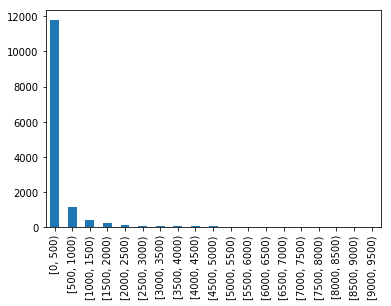

In [263]:
step = 500
s = data_train['PAGADO_A.1']
bin_range = np.arange(0, 10000, step)
out, bins  = pd.cut(s, bins=bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False).plot.bar()

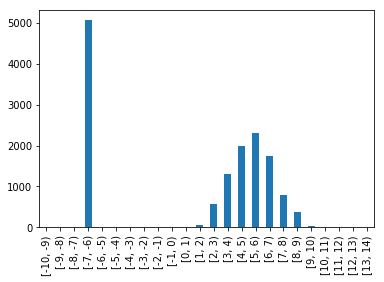

In [264]:
step = 1
s = np.log(data_train['PAGADO_A.1'] + 0.001)
bin_range = np.arange(-10, 15, step)
out, bins  = pd.cut(s, bins=bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False).plot.bar()

In [265]:
col_use = []

Transform the target value according to this new distr

In [266]:
data2 = data_train.copy()

data2['PAGADO_A.1_N'] = np.log(data2['PAGADO_A.1'] + 0.001)
col_use.append('PAGADO_A.1_N')

Create variables

In [267]:
data2['Cant_Diag'] = cant_diag(data2, 11)
data2['N_MESES'] = n_meses(data2, 12)

Normalize feature of paid last year:

In [268]:
data2['PAGADO_A_N'] = np.log(data2['PAGADO_A'] + 0.001)
col_use.append('PAGADO_A_N')

Lets z normalize other features of the data (it is better)

In [269]:
columns = ['EDAD', 'NRO_TRANS_A', 'C_DIAG', 'Cant_Diag', 'N_MESES', 'PRIMA_A.1']
meanvar = {}

for c in columns:
    z, u, sig = normalize(data2[c].values)
    data2[c + '_N'] = z
    meanvar[c] = (u, sig)
    col_use.append(c + '_N')

Mean Encode:

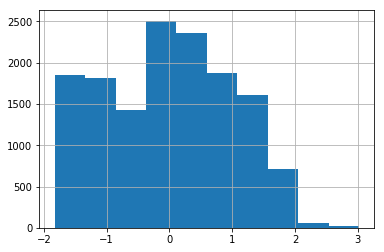

In [270]:
data2['EDAD_N'].hist()

In [271]:
data2['EDAD_C'] = ['A' if x <= -1 else 'B' if x <= 0 else 'C' if x <= 1 else 'D' for x in data2['EDAD_N']]
data2['EDAD_C'].value_counts()

C    4732
B    3861
A    3043
D    2624
Name: EDAD_C, dtype: int64

In [272]:
data2['E+G'] = data2['EDAD_C'] + '_' + data2['GENERO']
data2['E+G'].value_counts()

C_FEMENINO     2663
C_MASCULINO    2069
B_FEMENINO     1973
B_MASCULINO    1888
A_MASCULINO    1609
D_FEMENINO     1484
A_FEMENINO     1434
D_MASCULINO    1140
Name: E+G, dtype: int64

Run it on our columns

In [273]:
columns = ['GENERO', 'EDAD_C', 'E+G']
meancode = {}

for c in columns:
    meancode[c] = data2.groupby(c)['PAGADO_A.1'].mean()
    data2[c + '_ME'] = data2.groupby(c)['PAGADO_A.1'].transform('mean')
    col_use.append(c + '_ME')

In [274]:
data2['PERIODO_ME'] = data2['PERIODO'].map({'2014-2015': -1, '2015-2016': 0, '2016-2017': 1})
col_use.append('PERIODO_ME')

In [275]:
print(data2['PRODUCTO'].value_counts())

METROHUMANA                             6966
PRACTIHUMANA                            3860
BIENESTAR PLUS METROHUMANA              1531
BIENESTAR PLUS PRACTIHUMANA              625
PROTECCION OPTIMA PLUS VOZANDES          412
METROHUMANA POOL                         323
PRACTIHUMANA POOL                        281
CLUB SEGURO ARANCEL PRACTIHUMANA         104
METROACCIONISTAS                          73
CLUB SEGURO ARANCEL METROHUMANA           30
PROTECCION OPTIMA PLUS METROPOLITANO      23
CLUB SEGURO ROYAL HEALTH RED1             16
CLUB SEGURO ROYAL HEALTH RED 2            12
AMPARO TOTAL                               4
Name: PRODUCTO, dtype: int64


In [276]:
hp1 = data2.groupby('PRODUCTO')['PAGADO_A.1'].transform('sum')
hp2 = data2.groupby('PRODUCTO')['PAGADO_A.1'].transform('count')

uprior = data2['PAGADO_A.1'].mean()
alpha = 100
data2['PRODUCTO_ME'] = (alpha*uprior + hp1)/(alpha + hp2)

meancode['PRODUCTO'] = data2.groupby('PRODUCTO')['PRODUCTO_ME'].mean()
col_use.append('PRODUCTO_ME')

### Work with diagnostics data

In [277]:
data_d = pd.read_csv("nuevas\\pers_diag.csv", sep=',', encoding = "ISO-8859-1")
data_d.head(3)

,AFILIADO,PERIODO,DIAGNOSTICO_A,PAGADO_A.1,diag_f1,diag_f2,diag_f3
0,ABAD AREVALO CARLA MARA,2014-2015,H605,15.00,-0.526898,0.155419,0.012823
1,ABAD CABANILLA CARMEN BEATRIZ,2014-2015,"M130, A09X, J304, J310, K30X, N709, M214, N925...",152.75,0.228049,0.291613,-0.170468
2,ABAD ROMERO CECILIA EUGENIA,2014-2015,"J00X, M170, I10X, I450, M179, J40X, N739, N72X...",370.48,-0.857004,0.744933,-0.600182


In [278]:
diag_train = data_d.copy()
diag_train = diag_train[(diag_train.PERIODO == '2015-2016') | (diag_train.PERIODO == '2014-2015')]
diag_train = diag_train[['AFILIADO','PERIODO','diag_f1','diag_f2','diag_f3']]

In [279]:
data2 = data2.merge(diag_train, how = 'left', on=['AFILIADO','PERIODO'])

Check if the merge generated some null values:

In [280]:
data2['diag_f1'].isnull().values.any()

False

In [281]:
col_use = col_use + ['diag_f1','diag_f2','diag_f3']
del [data_d, diag_train]

## Dummies and Interactions

First we generate dummies for the discrete:

In [282]:
columns = ['GENERO', 'EDAD_C', 'E+G']
start = data2.shape[1]

for c in columns:
    data2 = pd.concat((data2, pd.get_dummies(data2[c],prefix=c+'_D')),axis=1)  

end = data2.shape[1]
col_use += list(data2.columns[start:end])

Now lets create Interactions (other than edad-genero)

Lets start with the continous ones:

In [283]:
columns = ['EDAD_N', 'NRO_TRANS_A_N', 'C_DIAG_N', 'Cant_Diag_N', 'N_MESES_N', 'PRIMA_A.1_N',
          'GENERO_ME', 'EDAD_C_ME', 'E+G_ME', 'PRODUCTO_ME', 'diag_f1', 'diag_f2', 'diag_f3']

for c in columns:
    for c2 in columns:
        data2[c + '_' + c2 + '_P_I'] = data2[c] * data2[c2]
        col_use.append(c + '_' + c2 + '_P_I')

Now between the discrete ones

In [284]:
columns = ['GENERO', 'EDAD_C', 'E+G']
start = data2.shape[1]

for c in columns:
    c2 = columns.copy()
    c2.remove(c)
    for e in c2:
        data2[c+'_'+e] = data2[c] + '_' + data2[e] 
        data2 = pd.concat((data2, pd.get_dummies(data2[c+'_'+e],prefix=c+'_'+e+'_D')),axis=1) 
        data2 = data2.drop([c+'_'+e], axis=1)  
        
end = data2.shape[1]
col_use += list(data2.columns[start:end])

### Final work

Extract columns with possible features:

In [285]:
data2 = data2[col_use]
data_train = data2.copy()
data_train.head(3)

,PAGADO_A.1_N,PAGADO_A_N,EDAD_N,NRO_TRANS_A_N,C_DIAG_N,Cant_Diag_N,N_MESES_N,PRIMA_A.1_N,GENERO_ME,EDAD_C_ME,...,E+G_GENERO_D_D_FEMENINO_FEMENINO,E+G_GENERO_D_D_MASCULINO_MASCULINO,E+G_EDAD_C_D_A_FEMENINO_A,E+G_EDAD_C_D_A_MASCULINO_A,E+G_EDAD_C_D_B_FEMENINO_B,E+G_EDAD_C_D_B_MASCULINO_B,E+G_EDAD_C_D_C_FEMENINO_C,E+G_EDAD_C_D_C_MASCULINO_C,E+G_EDAD_C_D_D_FEMENINO_D,E+G_EDAD_C_D_D_MASCULINO_D
0,2.708117,2.843804,0.196550,-0.544389,0.578644,-0.513700,-0.484495,0.230271,428.357258,427.970205,...,0,0,0,0,0,0,1,0,0,0
1,5.028809,5.910393,0.196550,1.573983,0.578644,2.007417,0.967411,0.631289,428.357258,427.970205,...,0,0,0,0,0,0,1,0,0,0
2,5.914802,6.169780,1.580864,1.715208,0.578644,1.503194,0.604435,-0.240697,428.357258,569.162866,...,1,0,0,0,0,0,0,0,1,0


Deleate unwanted data:

In [286]:
lst = [data2]
del lst

## Prepare Validation and Test data

In [287]:
data_v = data_valid.copy()
data_t = data_test.copy()
col_cre = []

In [288]:
data_v['PAGADO_A.1_N'] = np.log(data_v['PAGADO_A.1'] + 0.001)
data_t['PAGADO_A.1_N'] = np.log(data_t['PAGADO_A.1'] + 0.001)
col_cre.append('PAGADO_A.1_N')

In [289]:
data_v['Cant_Diag'] = cant_diag(data_v, 11)
data_t['Cant_Diag'] = cant_diag(data_t, 11)
data_v['N_MESES'] = n_meses(data_v, 12)
data_t['N_MESES'] = n_meses(data_t, 12)

In [290]:
data_v['PAGADO_A_N'] = np.log(data_v['PAGADO_A'] + 0.001)
data_t['PAGADO_A_N'] = np.log(data_t['PAGADO_A'] + 0.001)
col_cre.append('PAGADO_A_N')

In [291]:
for c in meanvar.keys():
    u, sig = meanvar[c]
    data_v[c + '_N'] = (data_v[c] - u)/sig
    data_t[c + '_N'] = (data_t[c] - u)/sig
    col_cre.append(c + '_N')

for c in meanvar.keys():
    print(data_v[c + '_N'].isnull().any())
    print(data_t[c + '_N'].isnull().any())    

False
False
False
False
False
False
False
False
False
False
False
False


In [292]:
data_v['EDAD_C'] = ['A' if x <= -1 else 'B' if x <= 0 else 'C' if x <= 1 else 'D' for x in data_v['EDAD_N']]
data_t['EDAD_C'] = ['A' if x <= -1 else 'B' if x <= 0 else 'C' if x <= 1 else 'D' for x in data_t['EDAD_N']]
data_v['E+G'] = data_v['EDAD_C'] + '_' + data_v['GENERO']
data_t['E+G'] = data_t['EDAD_C'] + '_' + data_t['GENERO']

In [293]:
for c in meancode.keys():
    data_v[c + '_ME'] = data_v[c].map(meancode[c])
    data_t[c + '_ME'] = data_t[c].map(meancode[c])
    col_cre.append(c + '_ME')

In [294]:
for c in meancode.keys():
    print(data_v[c + '_ME'].isnull().any())
    print(data_t[c + '_ME'].isnull().any())

False
False
False
False
False
False
False
False


In [295]:
data_v['PERIODO_ME'] = data_v['PERIODO'].map({'2014-2015': -1, '2015-2016': 0, '2016-2017': 1})
data_t['PERIODO_ME'] = data_t['PERIODO'].map({'2014-2015': -1, '2015-2016': 0, '2016-2017': 1})
col_cre.append('PERIODO_ME')

### Diagnostics

Work with diagnostic features for **validation data**:

In [296]:
data_d = pd.read_csv("nuevas\\pers_diag.csv", sep=',', encoding = "ISO-8859-1")
diag_train2 = data_d.copy()
diag_train2 = diag_train2[diag_train2.PERIODO == '2015-2016']


diag_train2['PERIODO'] = '2016-2017'
diag_train2 = diag_train2[['AFILIADO','PERIODO','diag_f1','diag_f2','diag_f3']]
diag_train2.head(3)

,AFILIADO,PERIODO,diag_f1,diag_f2,diag_f3
7450,ABAD ALAVA DIANA FERNANDA,2016-2017,0.398890,0.244201,0.956574
7451,ABAD AREVALO CARLA MARA,2016-2017,-0.093111,-0.010495,-0.242658
7452,ABAD CABANILLA CARMEN BEATRIZ,2016-2017,-0.097062,0.397756,-0.602566


Now we crete a mean feature to fill if person is missing:

In [297]:
mean_feat = diag_train2[['diag_f1','diag_f2','diag_f3']].mean(axis = 0)

Lets merge:

In [298]:
data_v = data_v.merge(diag_train2, how = 'left', on=['AFILIADO','PERIODO'])

Lets check for null values:

In [299]:
data_v['diag_f1'].isnull().values.any()

True

What percentage is null?

In [300]:
len(data_v['diag_f1'][data_v['diag_f1'].isnull()])/len(data_v['diag_f1'])

0.242

In [301]:
data_v = data_v.fillna(mean_feat)

In [302]:
data_v['diag_f1'].isnull().values.any()

False

Now lets work with diagnosis on the **test data**:

In [303]:
data_t = data_t.merge(diag_train2, how = 'left', on=['AFILIADO','PERIODO'])

In [304]:
data_t['diag_f1'].isnull().values.any()

True

In [305]:
len(data_t['diag_f1'][data_t['diag_f1'].isnull()])/len(data_t['diag_f1'])

0.2740423797881011

In [306]:
data_t = data_t.fillna(mean_feat)

In [307]:
data_t['diag_f1'].isnull().values.any()

False

In [308]:
col_cre = col_cre + ['diag_f1','diag_f2','diag_f3']

### Dummies and Interactions

In [309]:
columns = ['GENERO', 'EDAD_C', 'E+G']
start = data_v.shape[1]

for c in columns:
    data_v = pd.concat((data_v, pd.get_dummies(data_v[c],prefix=c+'_D')),axis=1)  
    data_t = pd.concat((data_t, pd.get_dummies(data_t[c],prefix=c+'_D')),axis=1)  

end = data_v.shape[1]
col_cre += list(data_v.columns[start:end])

In [310]:
columns = ['EDAD_N', 'NRO_TRANS_A_N', 'C_DIAG_N', 'Cant_Diag_N', 'N_MESES_N', 'PRIMA_A.1_N',
          'GENERO_ME', 'EDAD_C_ME', 'E+G_ME', 'PRODUCTO_ME', 'diag_f1', 'diag_f2', 'diag_f3']

for c in columns:
    for c2 in columns:
        data_v[c + '_' + c2 + '_P_I'] = data_v[c] * data_v[c2]
        data_t[c + '_' + c2 + '_P_I'] = data_t[c] * data_t[c2]
        col_cre.append(c + '_' + c2 + '_P_I')

In [311]:
columns = ['GENERO', 'EDAD_C', 'E+G']
start = data_v.shape[1]

for c in columns:
    c2 = columns.copy()
    c2.remove(c)
    for e in c2:
        data_v[c+'_'+e] = data_v[c] + '_' + data_v[e] 
        data_t[c+'_'+e] = data_t[c] + '_' + data_t[e]         
        data_v = pd.concat((data_v, pd.get_dummies(data_v[c+'_'+e], prefix=c+'_'+e+'_D')),axis=1) 
        data_t = pd.concat((data_t, pd.get_dummies(data_t[c+'_'+e], prefix=c+'_'+e+'_D')),axis=1)
        data_v = data_v.drop([c+'_'+e], axis=1) 
        data_t = data_t.drop([c+'_'+e], axis=1)
        
end = data_v.shape[1]
col_cre += list(data_v.columns[start:end])

In [312]:
data_v = data_v[col_cre]
data_t = data_t[col_cre]
data_valid = data_v.copy()
data_test = data_t.copy()
data_valid.head(3)

,PAGADO_A.1_N,PAGADO_A_N,EDAD_N,NRO_TRANS_A_N,C_DIAG_N,Cant_Diag_N,N_MESES_N,PRIMA_A.1_N,GENERO_ME,EDAD_C_ME,...,E+G_GENERO_D_D_FEMENINO_FEMENINO,E+G_GENERO_D_D_MASCULINO_MASCULINO,E+G_EDAD_C_D_A_FEMENINO_A,E+G_EDAD_C_D_A_MASCULINO_A,E+G_EDAD_C_D_B_FEMENINO_B,E+G_EDAD_C_D_B_MASCULINO_B,E+G_EDAD_C_D_C_FEMENINO_C,E+G_EDAD_C_D_C_MASCULINO_C,E+G_EDAD_C_D_D_FEMENINO_D,E+G_EDAD_C_D_D_MASCULINO_D
0,-6.907755,-6.907755,0.196550,-0.685614,-1.262378,-0.765811,-0.847471,-1.258783,428.357258,427.970205,...,0,0,0,0,0,0,1,0,0,0
1,-6.907755,5.164277,1.048436,-0.120715,0.578644,-0.261588,-0.121518,1.549550,331.175212,569.162866,...,0,1,0,0,0,0,0,0,0,1
2,3.322551,2.889872,1.261407,-0.544389,0.578644,-0.513700,-0.484495,0.587303,428.357258,569.162866,...,1,0,0,0,0,0,0,0,1,0


In [313]:
data_test.head(3)

,PAGADO_A.1_N,PAGADO_A_N,EDAD_N,NRO_TRANS_A_N,C_DIAG_N,Cant_Diag_N,N_MESES_N,PRIMA_A.1_N,GENERO_ME,EDAD_C_ME,...,E+G_GENERO_D_D_FEMENINO_FEMENINO,E+G_GENERO_D_D_MASCULINO_MASCULINO,E+G_EDAD_C_D_A_FEMENINO_A,E+G_EDAD_C_D_A_MASCULINO_A,E+G_EDAD_C_D_B_FEMENINO_B,E+G_EDAD_C_D_B_MASCULINO_B,E+G_EDAD_C_D_C_FEMENINO_C,E+G_EDAD_C_D_C_MASCULINO_C,E+G_EDAD_C_D_D_FEMENINO_D,E+G_EDAD_C_D_D_MASCULINO_D
0,5.176325,5.232183,0.249793,0.302960,0.578644,0.746859,0.241458,0.551489,428.357258,427.970205,...,0,0,0,0,0,0,1,0,0,0
1,6.418367,7.563757,0.303036,5.104603,0.578644,5.032758,2.056340,0.981540,428.357258,427.970205,...,0,0,0,0,0,0,1,0,0,0
2,6.482390,5.390901,1.634107,0.726634,0.578644,0.494747,0.604435,0.454444,428.357258,569.162866,...,1,0,0,0,0,0,0,0,1,0


## Run some tests:

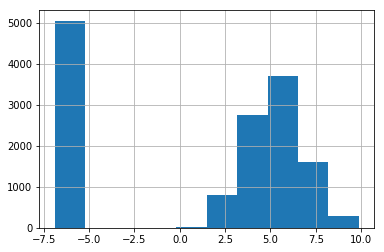

In [314]:
data_train['PAGADO_A.1_N'].hist()

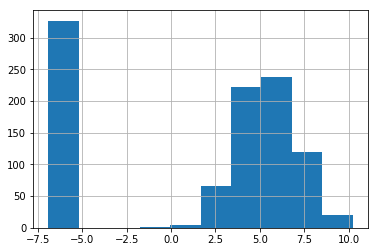

In [315]:
data_valid['PAGADO_A.1_N'].hist()

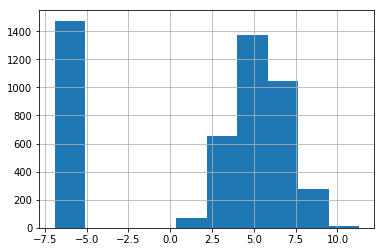

In [316]:
data_test['PAGADO_A.1_N'].hist()

Reset Index:

In [317]:
data_train = data_train.reset_index(drop=True)
data_valid = data_valid.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

## Write Data

In [318]:
data_train.to_csv("nuevas\\BASE_TRAIN.csv", encoding='utf-8', index=False)
data_valid.to_csv("nuevas\\BASE_VALID.csv", encoding='utf-8', index=False)
data_test.to_csv("nuevas\\BASE_TEST.csv", encoding='utf-8', index=False)